<a href="https://colab.research.google.com/github/jrebull/AnaliticaPrescriptiva/blob/main/Optimizacion_Red_Distribucion_Multinivel_Pyomov2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimización de Red Multinivel de Distribución Multiproducto
## Usando Programación Lineal con Pyomo

**Universidad Autónoma de Ciudad Juárez**  
**MIAAD - Maestría en Inteligencia Artificial y Analítica de Datos**  
**Dr. Gilberto Rivera Zárate**

---

### Descripción del Problema

Una empresa multinacional opera una red logística compuesta por:
- **Plantas manufactureras** que producen productos
- **Centros de distribución (CDs)** que reciben de las plantas
- **Clientes** que reciben de los CDs

**Objetivo**: Minimizar el costo total (producción + transporte) satisfaciendo todas las demandas y respetando capacidades.

### Ventajas de Programación Lineal

- **Optimalidad garantizada**: Encuentra la solución óptima global
- **Eficiencia computacional**: Resuelve problemas grandes rápidamente
- **Análisis de sensibilidad**: Permite estudiar impacto de cambios en parámetros
- **Interpretabilidad**: Resultados y duales tienen significado económico claro

## 1. Instalación de Dependencias

# Celda 1 - Instalación

In [1]:
# ============================================================
# INSTALACIÓN SILENCIOSA DE GLPK
# ============================================================

# Limpiar y instalar en silencio
!apt-get remove -y glpk-utils &> /dev/null || true
!apt-get update -qq &> /dev/null
!apt-get install -y glpk-utils libglpk-dev &> /dev/null

# Buscar glpsol
import subprocess
result = subprocess.run(['which', 'glpsol'], capture_output=True, text=True)

if result.stdout.strip():
    glpsol_path = result.stdout.strip()

    # Probar con Pyomo
    import pyomo.environ as pyo
    from pyomo.opt import SolverFactory

    solver = SolverFactory('glpk', executable=glpsol_path)

    if solver.available():
        # Modelo de prueba
        model = pyo.ConcreteModel()
        model.x = pyo.Var(domain=pyo.NonNegativeReals)
        model.obj = pyo.Objective(expr=model.x, sense=pyo.minimize)
        model.con = pyo.Constraint(expr=model.x >= 1)

        result = solver.solve(model, tee=False)

        if result.solver.termination_condition == pyo.TerminationCondition.optimal:
            print("✅ ¡GLPK DISPONIBLE EN PYOMO!")
            print(f"✅ Solución de prueba: x = {pyo.value(model.x):.2f}")
            print(f"\n🎯 USA ESTA RUTA EN TU CÓDIGO: {glpsol_path}")
        else:
            print("⚠️ GLPK: Solver responde pero con problemas")
    else:
        print("❌ GLPK: Pyomo no detecta GLPK")
else:
    print("❌ GLPK: glpsol no encontrado después de instalación")
    print("\n💡 Solución: Usa CBC que ya funciona:")
    print("   lp_model.solve(solver_name='cbc', time_limit=300)")

✅ ¡GLPK DISPONIBLE EN PYOMO!
✅ Solución de prueba: x = 1.00

🎯 USA ESTA RUTA EN TU CÓDIGO: /usr/bin/glpsol


## 2. Importación de Bibliotecas

In [2]:
# =' Módulo 1: Librerías Estándar de Python
import warnings
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional

# Módulo 2: Librerías de Terceros (Análisis y Visualización)
import gdown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import time
from IPython.display import display, HTML

# Módulo 3: Librerías de Terceros (Optimización - Pyomo)
import pyomo.environ as pyo
from pyomo.opt import SolverFactory, SolverStatus, TerminationCondition

# --- Configuración de entorno ---
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 3. Descarga de Datos desde Google Drive

In [3]:
class DataDownloader:
    """Descarga datos desde Google Drive."""

    FILE_IDS = {
        'centros': '1OxMfsW98iIfm8hqiul23Pmo8Iec1roX2',
        'clientes': '1v7UchVRnrKYPgYsir_0aCqk4W1Nj8o0O',
        'costos': '1Y4M_U7i_7k0-MVjU8itzGK4kYxzXdNFT',
        'plantas': '1Mq1C4Q5BXX-RUP6RyLlRDXMsLIxJPkMX',
        'productos': '1B1UGqYzLTE3uh_1-MdvuT22eAGA6BXNx'
    }

    @staticmethod
    def download_all_files() -> Dict[str, str]:
        """Descarga todos los archivos CSV desde Google Drive."""
        downloaded_files = {}

        for name, file_id in DataDownloader.FILE_IDS.items():
            url = f'https://drive.google.com/uc?id={file_id}'
            output = f'{name}.csv'

            print(f"📥 Descargando {name}.csv...")
            gdown.download(url, output, quiet=False)
            downloaded_files[name] = output

        print("\n✅ Todos los archivos descargados exitosamente!\n")
        return downloaded_files

# Descargar datos
files = DataDownloader.download_all_files()

📥 Descargando centros.csv...


Downloading...
From: https://drive.google.com/uc?id=1OxMfsW98iIfm8hqiul23Pmo8Iec1roX2
To: /content/centros.csv
100%|██████████| 1.30k/1.30k [00:00<00:00, 4.81MB/s]


📥 Descargando clientes.csv...


Downloading...
From: https://drive.google.com/uc?id=1v7UchVRnrKYPgYsir_0aCqk4W1Nj8o0O
To: /content/clientes.csv
100%|██████████| 12.8k/12.8k [00:00<00:00, 26.7MB/s]


📥 Descargando costos.csv...


Downloading...
From: https://drive.google.com/uc?id=1Y4M_U7i_7k0-MVjU8itzGK4kYxzXdNFT
To: /content/costos.csv
100%|██████████| 150k/150k [00:00<00:00, 43.9MB/s]


📥 Descargando plantas.csv...


Downloading...
From: https://drive.google.com/uc?id=1Mq1C4Q5BXX-RUP6RyLlRDXMsLIxJPkMX
To: /content/plantas.csv
100%|██████████| 527/527 [00:00<00:00, 2.44MB/s]


📥 Descargando productos.csv...


Downloading...
From: https://drive.google.com/uc?id=1B1UGqYzLTE3uh_1-MdvuT22eAGA6BXNx
To: /content/productos.csv
100%|██████████| 144/144 [00:00<00:00, 490kB/s]


✅ Todos los archivos descargados exitosamente!



## 4. Carga y Análisis Exploratorio de Datos

In [4]:
@dataclass
class NetworkData:
    """Encapsula todos los datos de la red de distribución."""
    plantas: pd.DataFrame
    centros: pd.DataFrame
    clientes: pd.DataFrame
    productos: pd.DataFrame
    costos: pd.DataFrame

    def get_summary(self) -> Dict[str, int]:
        """Retorna resumen de dimensiones de la red."""
        return {
            'num_plantas': len(self.plantas),
            'num_centros': len(self.centros),
            'num_clientes': len(self.clientes),
            'num_productos': len(self.productos)
        }


class DataLoader:
    """Carga y valida los datos."""

    @staticmethod
    def load_data(files: Dict[str, str]) -> NetworkData:
        """Carga todos los CSV en un objeto NetworkData."""
        print("📊 Cargando datos...\n")

        plantas = pd.read_csv(files['plantas'])
        centros = pd.read_csv(files['centros'])
        clientes = pd.read_csv(files['clientes'])
        productos = pd.read_csv(files['productos'])
        costos = pd.read_csv(files['costos'])

        network_data = NetworkData(
            plantas=plantas,
            centros=centros,
            clientes=clientes,
            productos=productos,
            costos=costos
        )

        DataLoader._print_summary(network_data)
        return network_data

    @staticmethod
    def _print_summary(data: NetworkData) -> None:
        """Imprime resumen de los datos cargados."""
        summary = data.get_summary()
        print("=" * 50)
        print("RESUMEN DE LA RED DE DISTRIBUCIÓN")
        print("=" * 50)
        print(f"🏭 Plantas: {summary['num_plantas']}")
        print(f"📦 Centros de Distribución: {summary['num_centros']}")
        print(f"🏪 Clientes: {summary['num_clientes']}")
        print(f"📋 Productos: {summary['num_productos']}")
        print("=" * 50 + "\n")

# Cargar datos
network_data = DataLoader.load_data(files)

📊 Cargando datos...

RESUMEN DE LA RED DE DISTRIBUCIÓN
🏭 Plantas: 15
📦 Centros de Distribución: 50
🏪 Clientes: 500
📋 Productos: 5



In [5]:
# Visualizar datasets
print("\n📊 PLANTAS")
display(network_data.plantas.head())

print("\n📊 CENTROS DE DISTRIBUCIÓN")
display(network_data.centros.head())

print("\n📊 CLIENTES")
display(network_data.clientes.head())

print("\n📊 PRODUCTOS")
display(network_data.productos.head())

print("\n📊 COSTOS")
display(network_data.costos.head())


📊 PLANTAS


,Planta,Producto,Capacidad_Produccion,Costo_Produccion
0,Planta_1,Producto_1,6685,12.26
1,Planta_1,Producto_2,11949,10.03
2,Planta_1,Producto_3,10051,17.34
3,Planta_1,Producto_4,9555,34.47
4,Planta_1,Producto_5,11396,27.28



📊 CENTROS DE DISTRIBUCIÓN


,Centro,Producto,Capacidad_Almacenamiento
0,Centro_1,Producto_1,5612
1,Centro_1,Producto_2,4363
2,Centro_1,Producto_3,9235
3,Centro_1,Producto_4,8486
4,Centro_1,Producto_5,4478



📊 CLIENTES


,Cliente,Producto,Demanda
0,Cliente_1,Producto_1,64
1,Cliente_1,Producto_2,84
2,Cliente_1,Producto_3,108
3,Cliente_1,Producto_4,90
4,Cliente_1,Producto_5,28



📊 PRODUCTOS


,Producto,Volumen_unitario,Peso_unitario
0,Producto_1,2.19,0.64
1,Producto_2,4.78,0.36
2,Producto_3,3.79,2.63
3,Producto_4,3.19,1.88
4,Producto_5,1.20,2.18



📊 COSTOS


,Planta,Centro,Producto,Cliente,Costo_Plant_Centro,Costo_Centro_Cliente
0,Planta_1,Centro_1,Producto_1,Cliente_1,8.09,10.42
1,Planta_1,Centro_1,Producto_2,Cliente_1,2.81,4.01
2,Planta_1,Centro_1,Producto_3,Cliente_1,7.61,3.87
3,Planta_1,Centro_1,Producto_4,Cliente_1,8.57,11.47
4,Planta_1,Centro_1,Producto_5,Cliente_1,2.65,4.02


In [6]:
# ============================================================================
# DIAGNÓSTICO DETALLADO DE ESTRUCTURA DE DATOS
# ============================================================================

print("\n" + "="*70)
print("🔍 DIAGNÓSTICO COMPLETO DE ESTRUCTURA DE CSV")
print("="*70)

print("\n📋 PRODUCTOS:")
print(network_data.productos.head(10))
print(f"Shape: {network_data.productos.shape}")

print("\n🏭 PLANTAS:")
print(network_data.plantas.head(10))
print(f"Shape: {network_data.plantas.shape}")

print("\n📦 CENTROS:")
print(network_data.centros.head(10))
print(f"Shape: {network_data.centros.shape}")

print("\n🏪 CLIENTES:")
print(network_data.clientes.head(10))
print(f"Shape: {network_data.clientes.shape}")

print("\n💰 COSTOS:")
print(network_data.costos.head(20))
print(f"Shape: {network_data.costos.shape}")
print(f"Columnas: {list(network_data.costos.columns)}")
print(f"\nValores únicos en columna 0: {network_data.costos.iloc[:, 0].unique()}")
if len(network_data.costos.columns) > 1:
    print(f"Valores únicos en columna 1: {network_data.costos.iloc[:, 1].unique()[:10]}...")


🔍 DIAGNÓSTICO COMPLETO DE ESTRUCTURA DE CSV

📋 PRODUCTOS:
     Producto  Volumen_unitario  Peso_unitario
0  Producto_1              2.19           0.64
1  Producto_2              4.78           0.36
2  Producto_3              3.79           2.63
3  Producto_4              3.19           1.88
4  Producto_5              1.20           2.18
Shape: (5, 3)

🏭 PLANTAS:
     Planta    Producto  Capacidad_Produccion  Costo_Produccion
0  Planta_1  Producto_1                  6685             12.26
1  Planta_1  Producto_2                 11949             10.03
2  Planta_1  Producto_3                 10051             17.34
3  Planta_1  Producto_4                  9555             34.47
4  Planta_1  Producto_5                 11396             27.28
5  Planta_2  Producto_1                 13666             34.47
6  Planta_2  Producto_2                 12849             11.87
7  Planta_2  Producto_3                  7747             24.65
8  Planta_2  Producto_4                  5189            

## 5. Preprocesamiento de Datos

In [7]:
class DataProcessor:
    """Procesa y transforma los datos para el modelo de optimización."""

    def __init__(self, data):
        self.data = data

    def get_sets(self) -> Dict:
        """Extrae conjuntos únicos."""
        return {
            'plantas': sorted(self.data.plantas['Planta'].unique()),
            'centros': sorted(self.data.centros['Centro'].unique()),
            'clientes': sorted(self.data.clientes['Cliente'].unique()),
            'productos': sorted(self.data.productos['Producto'].unique())
        }

    def get_capacidades_produccion(self) -> Dict:
        """Extrae capacidades de producción."""
        capacidades = {}
        for _, row in self.data.plantas.iterrows():
            capacidades[(row['Planta'], row['Producto'])] = row['Capacidad_Produccion']
        return capacidades

    def get_capacidades_almacenamiento(self) -> Dict:
        """Extrae capacidades de almacenamiento."""
        capacidades = {}
        for _, row in self.data.centros.iterrows():
            capacidades[(row['Centro'], row['Producto'])] = row['Capacidad_Almacenamiento']
        return capacidades

    def get_demanda(self) -> Dict:
        """Extrae demandas de clientes."""
        demandas = {}
        for _, row in self.data.clientes.iterrows():
            demandas[(row['Cliente'], row['Producto'])] = row['Demanda']
        return demandas

    def get_costos_produccion(self) -> Dict:
        """Extrae costos de producción."""
        costos = {}
        for _, row in self.data.plantas.iterrows():
            costos[(row['Planta'], row['Producto'])] = row['Costo_Produccion']
        return costos

    def get_costos_transporte_pc(self) -> Dict:
        """Extrae costos de transporte Planta -> Centro."""
        costos = {}
        for _, row in self.data.costos.iterrows():
            key = (row['Planta'], row['Centro'], row['Producto'])
            costos[key] = row['Costo_Plant_Centro']
        return costos

    def get_costos_transporte_cj(self) -> Dict:
        """Extrae costos de transporte Centro -> Cliente."""
        costos = {}
        for _, row in self.data.costos.iterrows():
            key = (row['Centro'], row['Cliente'], row['Producto'])
            costos[key] = row['Costo_Centro_Cliente']
        return costos

In [8]:
# Procesar datos
processor = DataProcessor(network_data)
sets = processor.get_sets()

# ======================================================
# 📊 VISUALIZACIÓN DE CONJUNTOS (VERSIÓN MEJORADA)
# ======================================================

# 1. Definir CSS para la caja de resumen
# (Usando estilos similares a los del dark mode anterior)
css = """
<style>
.summary-box {
    background: #2E3B2E; /* Verde oscuro */
    border-left: 5px solid #81C784; /* Verde claro */
    border-radius: 8px;
    padding: 18px 25px;
    margin: 15px 0;
    font-family: -apple-system, BlinkMacSystemFont, "Segoe UI", Roboto, "Helvetica Neue", Arial, sans-serif;
    color: #f0f0f0;
    box-shadow: 0 3px 5px rgba(0,0,0,0.2);
}
.summary-box h3 {
    margin: 0 0 15px 0;
    padding-bottom: 10px;
    border-bottom: 2px solid #81C784;
    color: #ffffff;
    font-size: 1.3em;
}
.summary-box ul {
    list-style: none;
    padding-left: 0;
}
.summary-box li {
    font-size: 1.1em;
    margin-bottom: 12px;
    line-height: 1.4;
    display: flex;
    align-items: center;
}
.summary-box .count {
    font-weight: bold;
    color: #ffeb3b; /* Amarillo brillante */
    background: rgba(0,0,0,0.2);
    padding: 3px 8px;
    border-radius: 4px;
    margin-right: 12px;
    white-space: nowrap; /* Evita que el texto se parta */
}
.summary-box .examples {
    font-family: monospace;
    color: #b0b0b0; /* Gris claro */
    font-size: 0.9em;
    /* Evita el desbordamiento de texto */
    word-break: break-all;
}
</style>
"""
display(HTML(css))

# 2. Construir el HTML dinámicamente
html_output = '<div class="summary-box"><h3>📊 Resumen de Conjuntos</h3><ul>'

# Límite de ejemplos a mostrar antes de truncar
limite_ejemplos = 5

for name, values in sets.items():
    count = len(values)
    name_capitalized = name.capitalize()

    # Crear la lista de ejemplos truncada
    if count > limite_ejemplos:
        # Mapea a str para asegurar que todo sea string
        ejemplos_str = ", ".join(map(str, values[:limite_ejemplos]))
        ejemplos = f"[{ejemplos_str}, ... (y {count - limite_ejemplos} más)]"
    else:
        ejemplos_str = ", ".join(map(str, values))
        ejemplos = f"[{ejemplos_str}]"

    # Añadir al HTML
    html_output += f"""
    <li>
        <span class="count">{count} {name_capitalized}</span>
        <span class="examples">{ejemplos}</span>
    </li>
    """

html_output += '</ul></div>'

# 3. Mostrar el resultado
display(HTML(html_output))

## 6. Modelo de Programación Lineal con Pyomo

In [9]:
class DistributionNetworkLP:
    """Modelo de Programación Lineal para red de distribución multinivel."""

    def __init__(self, processor: DataProcessor):
        self.processor = processor
        self.model = None
        self.results = None

        # Obtener datos
        self.sets = processor.get_sets()
        self.cap_prod = processor.get_capacidades_produccion()
        self.cap_alm = processor.get_capacidades_almacenamiento()
        self.demanda = processor.get_demanda()
        self.costo_prod = processor.get_costos_produccion()
        self.costo_trans_pc = processor.get_costos_transporte_pc()
        self.costo_trans_cj = processor.get_costos_transporte_cj()

    def build_model(self):
        """Construye el modelo de optimización."""
        print("\n🔨 Construyendo modelo de Programación Lineal...\n")

        model = pyo.ConcreteModel(name="Red_Distribucion_Multinivel")

        # ==================== CONJUNTOS ====================
        model.P = pyo.Set(initialize=self.sets['plantas'], doc='Plantas')
        model.C = pyo.Set(initialize=self.sets['centros'], doc='Centros')
        model.J = pyo.Set(initialize=self.sets['clientes'], doc='Clientes')
        model.K = pyo.Set(initialize=self.sets['productos'], doc='Productos')

        # =============== VARIABLES DE DECISIÓN ===============
        model.x = pyo.Var(
            model.P, model.C, model.K,
            domain=pyo.NonNegativeReals,
            doc='Flujo de producto k de planta p a centro c'
        )

        model.y = pyo.Var(
            model.C, model.J, model.K,
            domain=pyo.NonNegativeReals,
            doc='Flujo de producto k de centro c a cliente j'
        )

        # ================= FUNCIÓN OBJETIVO =================
        def objetivo_rule(model):
            # Costo de producción
            costo_produccion = sum(
                self.costo_prod.get((p, k), 0) * model.x[p, c, k]
                for p in model.P
                for c in model.C
                for k in model.K
            )

            # Costo de transporte Planta -> Centro
            costo_trans_pc = sum(
                self.costo_trans_pc.get((p, c, k), 0) * model.x[p, c, k]
                for p in model.P
                for c in model.C
                for k in model.K
            )

            # Costo de transporte Centro -> Cliente
            costo_trans_cj = sum(
                self.costo_trans_cj.get((c, j, k), 0) * model.y[c, j, k]
                for c in model.C
                for j in model.J
                for k in model.K
            )

            return costo_produccion + costo_trans_pc + costo_trans_cj

        model.objetivo = pyo.Objective(rule=objetivo_rule, sense=pyo.minimize)

        # =================== RESTRICCIONES ===================

        # 1. Capacidad de Producción
        def capacidad_produccion_rule(model, p, k):
            return sum(model.x[p, c, k] for c in model.C) <= self.cap_prod.get((p, k), 0)

        model.capacidad_produccion = pyo.Constraint(
            model.P, model.K,
            rule=capacidad_produccion_rule,
            doc='Capacidad de producción de plantas'
        )

        # 2. Capacidad de Almacenamiento
        def capacidad_almacenamiento_rule(model, c, k):
            return sum(model.x[p, c, k] for p in model.P) <= self.cap_alm.get((c, k), 0)

        model.capacidad_almacenamiento = pyo.Constraint(
            model.C, model.K,
            rule=capacidad_almacenamiento_rule,
            doc='Capacidad de almacenamiento de centros'
        )

        # 3. Balance de Flujo en Centros
        def balance_flujo_rule(model, c, k):
            entrada = sum(model.x[p, c, k] for p in model.P)
            salida = sum(model.y[c, j, k] for j in model.J)
            return entrada == salida

        model.balance_flujo = pyo.Constraint(
            model.C, model.K,
            rule=balance_flujo_rule,
            doc='Balance de flujo en centros de distribución'
        )

        # 4. Satisfacción de Demanda
        def satisfaccion_demanda_rule(model, j, k):
            return sum(model.y[c, j, k] for c in model.C) >= self.demanda.get((j, k), 0)

        model.satisfaccion_demanda = pyo.Constraint(
            model.J, model.K,
            rule=satisfaccion_demanda_rule,
            doc='Satisfacción de demanda de clientes'
        )

        self.model = model
        print("✅ Modelo construido exitosamente!")
        self._print_model_statistics()

    def _print_model_statistics(self):
        """Imprime estadísticas del modelo."""
        num_vars = len([v for v in self.model.component_data_objects(pyo.Var)])
        num_constraints = len([c for c in self.model.component_data_objects(pyo.Constraint)])

        print("\n📊 ESTADÍSTICAS DEL MODELO")
        print("=" * 50)
        print(f"Variables de decisión: {num_vars}")
        print(f"Restricciones: {num_constraints}")
        print(f"Plantas: {len(self.sets['plantas'])}")
        print(f"Centros: {len(self.sets['centros'])}")
        print(f"Clientes: {len(self.sets['clientes'])}")
        print(f"Productos: {len(self.sets['productos'])}")
        print("=" * 50 + "\n")

    def solve(self, solver_name='cbc', time_limit=300, mip_gap=0.01):
        """Resuelve el modelo de optimización."""
        if self.model is None:
            raise ValueError("Primero construya el modelo con build_model()")

        print(f"🚀 Resolviendo con {solver_name.upper()}...\n")

        # Configurar solver
        solver = SolverFactory(solver_name)

        if solver_name == 'gurobi':
            solver.options['TimeLimit'] = time_limit
            solver.options['MIPGap'] = mip_gap
        elif solver_name == 'cbc':
            solver.options['seconds'] = time_limit
            solver.options['ratio'] = mip_gap

        # Resolver
        self.results = solver.solve(self.model, tee=True)

        # Verificar estado
        if (self.results.solver.status == SolverStatus.ok and
            self.results.solver.termination_condition == TerminationCondition.optimal):
            print("\n✅ ¡Solución óptima encontrada!")
            self._print_solution_summary()
        elif self.results.solver.termination_condition == TerminationCondition.infeasible:
            print("\n❌ El problema es INFACTIBLE")
        else:
            print(f"\n⚠️ Estado del solver: {self.results.solver.status}")
            print(f"Condición de terminación: {self.results.solver.termination_condition}")

    def _print_solution_summary(self):
        """Imprime resumen de la solución."""
        if self.results is None:
            return

        print("\n" + "=" * 60)
        print("RESUMEN DE LA SOLUCIÓN ÓPTIMA")
        print("=" * 60)

        # Costo total
        costo_total = pyo.value(self.model.objetivo)
        print(f"\n💰 Costo Total Mínimo: ${costo_total:,.2f}")

        # Desglose de costos
        costo_produccion = sum(
            self.costo_prod.get((p, k), 0) * pyo.value(self.model.x[p, c, k])
            for p in self.model.P
            for c in self.model.C
            for k in self.model.K
        )

        costo_trans_pc = sum(
            self.costo_trans_pc.get((p, c, k), 0) * pyo.value(self.model.x[p, c, k])
            for p in self.model.P
            for c in self.model.C
            for k in self.model.K
        )

        costo_trans_cj = sum(
            self.costo_trans_cj.get((c, j, k), 0) * pyo.value(self.model.y[c, j, k])
            for c in self.model.C
            for j in self.model.J
            for k in self.model.K
        )

        print(f"   • Costo de Producción: ${costo_produccion:,.2f} ({costo_produccion/costo_total*100:.1f}%)")
        print(f"   • Transporte Planta→Centro: ${costo_trans_pc:,.2f} ({costo_trans_pc/costo_total*100:.1f}%)")
        print(f"   • Transporte Centro→Cliente: ${costo_trans_cj:,.2f} ({costo_trans_cj/costo_total*100:.1f}%)")

        # Satisfacción de demanda
        demanda_total = sum(self.demanda.values())
        demanda_satisfecha = sum(
            pyo.value(self.model.y[c, j, k])
            for c in self.model.C
            for j in self.model.J
            for k in self.model.K
        )
        satisfaccion = (demanda_satisfecha / demanda_total) * 100 if demanda_total > 0 else 0
        print(f"\n📊 Satisfacción de Demanda: {satisfaccion:.2f}%")

        # Utilización de capacidades
        produccion_total = sum(
            pyo.value(self.model.x[p, c, k])
            for p in self.model.P
            for c in self.model.C
            for k in self.model.K
        )
        capacidad_total_produccion = sum(self.cap_prod.values())
        util_produccion = (produccion_total / capacidad_total_produccion) * 100 if capacidad_total_produccion > 0 else 0
        print(f"🏭 Utilización Promedio de Plantas: {util_produccion:.2f}%")

        print("=" * 60 + "\n")

    def get_solution_dataframes(self) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """Extrae la solución en formato de DataFrames."""
        if self.model is None or self.results is None:
            raise ValueError("Primero resuelva el modelo")

        # Flujo Planta -> Centro
        flujo_pc = []
        for p in self.model.P:
            for c in self.model.C:
                for k in self.model.K:
                    valor = pyo.value(self.model.x[p, c, k])
                    if valor > 0.01:
                        flujo_pc.append({
                            'planta': p,
                            'centro': c,
                            'producto': k,
                            'cantidad': valor
                        })

        # Flujo Centro -> Cliente
        flujo_cj = []
        for c in self.model.C:
            for j in self.model.J:
                for k in self.model.K:
                    valor = pyo.value(self.model.y[c, j, k])
                    if valor > 0.01:
                        flujo_cj.append({
                            'centro': c,
                            'cliente': j,
                            'producto': k,
                            'cantidad': valor
                        })

        return pd.DataFrame(flujo_pc), pd.DataFrame(flujo_cj)

# Crear y construir modelo
lp_model = DistributionNetworkLP(processor)
lp_model.build_model()


🔨 Construyendo modelo de Programación Lineal...

✅ Modelo construido exitosamente!

📊 ESTADÍSTICAS DEL MODELO
Variables de decisión: 5150
Restricciones: 615
Plantas: 3
Centros: 10
Clientes: 100
Productos: 5



In [10]:
# ============================================================================
# 📐 FORMULACIÓN MATEMÁTICA DEL PROBLEMA (VERSIÓN DARK MODE)
# ============================================================================

from IPython.display import display, Markdown, HTML

# Calcular dimensiones del modelo
num_plantas = len(lp_model.sets['plantas'])
num_centros = len(lp_model.sets['centros'])
num_clientes = len(lp_model.sets['clientes'])
num_productos = len(lp_model.sets['productos'])

num_vars_x = num_plantas * num_centros * num_productos
num_vars_y = num_centros * num_clientes * num_productos
total_vars = num_vars_x + num_vars_y

# CSS para estilos (Dark Mode)
css = """
<style>
.sets-box, .params-box, .vars-box, .constraint-box {
    color: #e0e0e0;
}
.math-box {
    background: linear-gradient(135deg, #5a68c2 0%, #613b82 100%);
    border-radius: 10px;
    padding: 20px;
    margin: 20px 0;
    color: white;
    box-shadow: 0 4px 6px rgba(0,0,0,0.3);
}
.constraint-box {
    background: #2c2c2c;
    border-left: 4px solid #5da5f5;
    padding: 15px;
    margin: 10px 0;
    border-radius: 5px;
}
.objective-box {
    background: linear-gradient(135deg, #d479df 0%, #e04a5c 100%);
    border-radius: 10px;
    padding: 20px;
    margin: 20px 0;
    color: white;
    box-shadow: 0 4px 6px rgba(0,0,0,0.3);
}
.sets-box {
    background: #2e3b2e;
    border-left: 4px solid #81c784;
    padding: 15px;
    margin: 10px 0;
    border-radius: 5px;
}
.params-box {
    background: #3e3529;
    border-left: 4px solid #ffb74d;
    padding: 15px;
    margin: 10px 0;
    border-radius: 5px;
}
.vars-box {
    background: #2b3740;
    border-left: 4px solid #64b5f6;
    padding: 15px;
    margin: 10px 0;
    border-radius: 5px;
}
h3 {
    margin-top: 30px;
    color: #e8e8e8;
    border-bottom: 3px solid #764ba2;
    padding-bottom: 10px;
}
.highlight {
    background: #ffeb3b;
    padding: 2px 6px;
    border-radius: 3px;
    color: #000;
    font-weight: bold;
}
</style>
"""

display(HTML(css))

# Título principal
display(Markdown("""
# 🎯 Formulación Matemática Completa
## Problema de Optimización de Red de Distribución Multinivel
"""))

# Conjuntos
display(HTML(f"""
<div class="sets-box">
<h3>📦 CONJUNTOS (Índices)</h3>
<ul style="list-style-type: none; padding-left: 0;">
    <li><strong>P</strong>: Conjunto de <span class="highlight">plantas manufactureras</span>, indexadas por <em>p</em>
        → <strong>{num_plantas}</strong> plantas</li>
    <li><strong>C</strong>: Conjunto de <span class="highlight">centros de distribución</span>, indexados por <em>c</em>
        → <strong>{num_centros}</strong> centros</li>
    <li><strong>J</strong>: Conjunto de <span class="highlight">clientes</span>, indexados por <em>j</em>
        → <strong>{num_clientes}</strong> clientes</li>
    <li><strong>K</strong>: Conjunto de <span class="highlight">productos</span>, indexados por <em>k</em>
        → <strong>{num_productos}</strong> productos</li>
</ul>
</div>
"""))

# Parámetros
display(HTML(f"""
<div class="params-box">
<h3>📊 PARÁMETROS (Datos del Problema)</h3>
<table style="width:100%; border-collapse: collapse;">
<tr style="border-bottom: 2px solid #ffb74d;">
    <th style="text-align:left; padding:10px;">Parámetro</th>
    <th style="text-align:left; padding:10px;">Descripción</th>
    <th style="text-align:right; padding:10px;">Dimensión</th>
</tr>
<tr>
    <td style="padding:8px;"><strong>d<sub>j,k</sub></strong></td>
    <td style="padding:8px;">Demanda del cliente <em>j</em> para el producto <em>k</em></td>
    <td style="text-align:right; padding:8px;">{num_clientes} × {num_productos}</td>
</tr>
<tr style="background:#3a3024;">
    <td style="padding:8px;"><strong>cap<sup>prod</sup><sub>p,k</sub></strong></td>
    <td style="padding:8px;">Capacidad máxima de producción del producto <em>k</em> en la planta <em>p</em></td>
    <td style="text-align:right; padding:8px;">{num_plantas} × {num_productos}</td>
</tr>
<tr>
    <td style="padding:8px;"><strong>cap<sup>alm</sup><sub>c,k</sub></strong></td>
    <td style="padding:8px;">Capacidad máxima de almacenamiento del producto <em>k</em> en el centro <em>c</em></td>
    <td style="text-align:right; padding:8px;">{num_centros} × {num_productos}</td>
</tr>
<tr style="background:#3a3024;">
    <td style="padding:8px;"><strong>cost<sup>prod</sup><sub>p,k</sub></strong></td>
    <td style="padding:8px;">Costo de producción por unidad del producto <em>k</em> en la planta <em>p</em></td>
    <td style="text-align:right; padding:8px;">{num_plantas} × {num_productos}</td>
</tr>
<tr>
    <td style="padding:8px;"><strong>cost<sup>pc</sup><sub>p,c,k</sub></strong></td>
    <td style="padding:8px;">Costo de transporte por unidad del producto <em>k</em> desde planta <em>p</em> al centro <em>c</em></td>
    <td style="text-align:right; padding:8px;">{num_plantas} × {num_centros} × {num_productos}</td>
</tr>
<tr style="background:#3a3024;">
    <td style="padding:8px;"><strong>cost<sup>cj</sup><sub>c,j,k</sub></strong></td>
    <td style="padding:8px;">Costo de transporte por unidad del producto <em>k</em> desde centro <em>c</em> al cliente <em>j</em></td>
    <td style="text-align:right; padding:8px;">{num_centros} × {num_clientes} × {num_productos}</td>
</tr>
</table>
</div>
"""))

# Variables
display(HTML(f"""
<div class="vars-box">
<h3>🔢 VARIABLES DE DECISIÓN</h3>
<ul style="list-style-type: none; padding-left: 0;">
    <li><strong>x<sub>p,c,k</sub></strong> ≥ 0: Cantidad del producto <em>k</em> enviada de la planta <em>p</em> al centro <em>c</em>
        <br><em style="color:#a0a0a0;">Total de variables: <strong>{num_vars_x:,}</strong></em></li>
    <br>
    <li><strong>y<sub>c,j,k</sub></strong> ≥ 0: Cantidad del producto <em>k</em> enviada del centro <em>c</em> al cliente <em>j</em>
        <br><em style="color:#a0a0a0;">Total de variables: <strong>{num_vars_y:,}</strong></em></li>
</ul>
<div style="background:#2a4a6b; color: #f0f0f0; padding:10px; border-radius:5px; margin-top:10px;">
    <strong>📊 TOTAL DE VARIABLES DE DECISIÓN: {total_vars:,}</strong>
</div>
</div>
"""))

# Función Objetivo
display(Markdown("""
### 🎯 FUNCIÓN OBJETIVO

**Minimizar el costo total:**
"""))

display(HTML("""
<div class="objective-box">
<h2 style="text-align:center; color:white; margin:0;">min Z</h2>
<hr style="border-color:rgba(255,255,255,0.3);">
<div style="font-size:18px; text-align:center; font-family:monospace;">
<strong>Z = Costo Producción + Costo Transporte (P→C) + Costo Transporte (C→J)</strong>
</div>
<br>
<div style="font-size:16px; font-family:monospace; background:rgba(0,0,0,0.3); padding:15px; border-radius:5px;">
Z = ∑<sub>p∈P</sub> ∑<sub>c∈C</sub> ∑<sub>k∈K</sub> x<sub>p,c,k</sub> · cost<sup>prod</sup><sub>p,k</sub>
<br><br>
&nbsp;&nbsp;&nbsp;&nbsp;+ ∑<sub>p∈P</sub> ∑<sub>c∈C</sub> ∑<sub>k∈K</sub> x<sub>p,c,k</sub> · cost<sup>pc</sup><sub>p,c,k</sub>
<br><br>
&nbsp;&nbsp;&nbsp;&nbsp;+ ∑<sub>c∈C</sub> ∑<sub>j∈J</sub> ∑<sub>k∈K</sub> y<sub>c,j,k</sub> · cost<sup>cj</sup><sub>c,j,k</sub>
</div>
</div>
"""))

# Restricciones
display(Markdown("""
### ⚖️ RESTRICCIONES
"""))

# Restricción 1
display(HTML(f"""
<div class="constraint-box">
<h4 style="color:#5da5f5; margin-top:0;">1️⃣ Satisfacción de la Demanda</h4>
<p><strong>Cada cliente debe recibir al menos la cantidad que demanda de cada producto.</strong></p>
<div style="background:#222; color: #f5f5f5; padding:10px; border-radius:3px; font-size:16px; font-family:monospace;">
∑<sub>c∈C</sub> y<sub>c,j,k</sub> ≥ d<sub>j,k</sub> &nbsp;&nbsp;&nbsp; ∀ j ∈ J, k ∈ K
</div>
<p style="margin-top:10px; color:#a0a0a0;">
<em>→ Total de restricciones: <strong>{num_clientes * num_productos:,}</strong> ({num_clientes} clientes × {num_productos} productos)</em>
</p>
</div>
"""))

# Restricción 2
display(HTML(f"""
<div class="constraint-box">
<h4 style="color:#5da5f5; margin-top:0;">2️⃣ Balance de Flujo en Centros de Distribución</h4>
<p><strong>Lo que entra a un centro debe salir hacia los clientes (conservación de flujo).</strong></p>
<div style="background:#222; color: #f5f5f5; padding:10px; border-radius:3px; font-size:16px; font-family:monospace;">
∑<sub>p∈P</sub> x<sub>p,c,k</sub> = ∑<sub>j∈J</sub> y<sub>c,j,k</sub> &nbsp;&nbsp;&nbsp; ∀ c ∈ C, k ∈ K
</div>
<p style="margin-top:10px; color:#a0a0a0;">
<em>→ Total de restricciones: <strong>{num_centros * num_productos:,}</strong> ({num_centros} centros × {num_productos} productos)</em>
</p>
</div>
"""))

# Restricción 3
display(HTML(f"""
<div class="constraint-box">
<h4 style="color:#5da5f5; margin-top:0;">3️⃣ Capacidad de Producción</h4>
<p><strong>La cantidad producida en cada planta no debe exceder su capacidad.</strong></p>
<div style="background:#222; color: #f5f5f5; padding:10px; border-radius:3px; font-size:16px; font-family:monospace;">
∑<sub>c∈C</sub> x<sub>p,c,k</sub> ≤ cap<sup>prod</sup><sub>p,k</sub> &nbsp;&nbsp;&nbsp; ∀ p ∈ P, k ∈ K
</div>
<p style="margin-top:10px; color:#a0a0a0;">
<em>→ Total de restricciones: <strong>{num_plantas * num_productos:,}</strong> ({num_plantas} plantas × {num_productos} productos)</em>
</p>
</div>
"""))

# Restricción 4
display(HTML(f"""
<div class="constraint-box">
<h4 style="color:#5da5f5; margin-top:0;">4️⃣ Capacidad de Almacenamiento</h4>
<p><strong>La cantidad almacenada en cada centro no debe exceder su capacidad.</strong></p>
<div style="background:#222; color: #f5f5f5; padding:10px; border-radius:3px; font-size:16px; font-family:monospace;">
∑<sub>p∈P</sub> x<sub>p,c,k</sub> ≤ cap<sup>alm</sup><sub>c,k</sub> &nbsp;&nbsp;&nbsp; ∀ c ∈ C, k ∈ K
</div>
<p style="margin-top:10px; color:#a0a0a0;">
<em>→ Total de restricciones: <strong>{num_centros * num_productos:,}</strong> ({num_centros} centros × {num_productos} productos)</em>
</p>
</div>
"""))

# Restricción 5
display(HTML("""
<div class="constraint-box">
<h4 style="color:#5da5f5; margin-top:0;">5️⃣ No Negatividad</h4>
<p><strong>No se pueden enviar cantidades negativas de productos.</strong></p>
<div style="background:#222; color: #f5f5f5; padding:10px; border-radius:3px; font-size:16px; font-family:monospace;">
x<sub>p,c,k</sub> ≥ 0 &nbsp;&nbsp;&nbsp; ∀ p ∈ P, c ∈ C, k ∈ K
<br>
y<sub>c,j,k</sub> ≥ 0 &nbsp;&nbsp;&nbsp; ∀ c ∈ C, j ∈ J, k ∈ K
</div>
<p style="margin-top:10px; color:#a0a0a0;">
<em>→ Implícito en la definición de variables</em>
</p>
</div>
"""))

# Resumen
total_constraints = (num_clientes * num_productos +
                    num_centros * num_productos +
                    num_plantas * num_productos +
                    num_centros * num_productos)

display(HTML(f"""
<div class="math-box">
<h2 style="text-align:center; color:white; margin:0;">📈 RESUMEN DEL MODELO</h2>
<hr style="border-color:rgba(255,255,255,0.3);">
<table style="width:100%; color:white; font-size:16px;">
<tr>
    <td style="padding:10px;"><strong>Variables de decisión:</strong></td>
    <td style="text-align:right; padding:10px;"><strong>{total_vars:,}</strong></td>
</tr>
<tr>
    <td style="padding:10px;"><strong>Restricciones totales:</strong></td>
    <td style="text-align:right; padding:10px;"><strong>{total_constraints:,}</strong></td>
</tr>
<tr>
    <td style="padding:10px;"><strong>Tipo de problema:</strong></td>
    <td style="text-align:right; padding:10px;"><strong>Programación Lineal</strong></td>
</tr>
<tr>
    <td style="padding:10px;"><strong>Método de solución:</strong></td>
    <td style="text-align:right; padding:10px;"><strong>Pyomo + CBC/GLPK</strong></td>
</tr>
</table>
</div>
"""))

print("\n" + "="*70)
print("✅ Formulación matemática completa visualizada")
print("="*70)


# 🎯 Formulación Matemática Completa
## Problema de Optimización de Red de Distribución Multinivel


Parámetro,Descripción,Dimensión
"dj,k",Demanda del cliente j para el producto k,100 × 5
"capprodp,k",Capacidad máxima de producción del producto k en la planta p,3 × 5
"capalmc,k",Capacidad máxima de almacenamiento del producto k en el centro c,10 × 5
"costprodp,k",Costo de producción por unidad del producto k en la planta p,3 × 5
"costpcp,c,k",Costo de transporte por unidad del producto k desde planta p al centro c,3 × 10 × 5
"costcjc,j,k",Costo de transporte por unidad del producto k desde centro c al cliente j,10 × 100 × 5



### 🎯 FUNCIÓN OBJETIVO

**Minimizar el costo total:**



### ⚖️ RESTRICCIONES


Variables de decisión:,"5,150"
Restricciones totales:,615
Tipo de problema:,Programación Lineal
Método de solución:,Pyomo + CBC/GLPK



✅ Formulación matemática completa visualizada


## 7. Resolución del Modelo

In [11]:
"""## 7. Resolución del Modelo"""

# Resolver con GLPK
print("\n" + "="*60)
print("RESOLVIENDO EL MODELO DE OPTIMIZACIÓN")
print("="*60)

lp_model.solve(solver_name='glpk', time_limit=300)

# Verificar que se resolvió exitosamente
if lp_model.results is None:
    raise RuntimeError("❌ El modelo NO se resolvió. Verifica la instalación de GLPK.")
elif lp_model.results.solver.termination_condition != pyo.TerminationCondition.optimal:
    raise RuntimeError(f"❌ El modelo NO encontró solución óptima: {lp_model.results.solver.termination_condition}")

print("\n✅ Modelo resuelto exitosamente - puedes continuar con visualizaciones")


RESOLVIENDO EL MODELO DE OPTIMIZACIÓN
🚀 Resolviendo con GLPK...

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /tmp/tmpdukfjb9y.glpk.raw --wglp /tmp/tmprza6k2z5.glpk.glp --cpxlp
 /tmp/tmpcq2yjrnz.pyomo.lp
Reading problem data from '/tmp/tmpcq2yjrnz.pyomo.lp'...
615 rows, 5150 columns, 10450 non-zeros
18604 lines were read
Writing problem data to '/tmp/tmprza6k2z5.glpk.glp'...
17933 lines were written
GLPK Simplex Optimizer 5.0
615 rows, 5150 columns, 10450 non-zeros
Preprocessing...
615 rows, 5150 columns, 10450 non-zeros
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 615
      0: obj =   0.000000000e+00 inf =   5.635e+04 (500)
    517: obj =   1.675031760e+06 inf =   0.000e+00 (0)
*  1144: obj =   1.301579730e+06 inf =   0.000e+00 (0) 1
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 3.8 Mb (4031101 bytes)
Wri

## 8. Visualización de Resultados

In [12]:
# --- Importaciones necesarias ---
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd  # Asegúrate de tener pandas importado
import pyomo.environ as pyo
from matplotlib.ticker import FuncFormatter
import pyomo.environ as pyo

# (Asumiendo que 'DistributionNetworkLP' y 'lp_model' ya existen)
# (Asumiendo que 'pyo' está importado)

# ============================================================================
# 📊 CLASE DE ANÁLISIS MEJORADA (VERSIÓN 3 - LÍMITE DE CLIENTES)
# ============================================================================

class SolutionAnalyzer:
    """
    Analiza y visualiza la solución óptima.
    (Versión con límite de clientes para gráficos más limpios).
    """

    def __init__(self, lp_model: DistributionNetworkLP, max_clients_plot=9):
        self.lp_model = lp_model
        self.model = lp_model.model
        self.sets = lp_model.sets

        # Límite de clientes a mostrar antes de agrupar o cambiar de gráfico
        self.max_clients_plot = max_clients_plot
        # Umbral para cambiar a histograma (un poco más alto que el límite de agrupación)
        self.histogram_threshold = max_clients_plot * 2

        sns.set_theme(style="whitegrid", palette="muted")
        plt.rcParams['figure.dpi'] = 100

    def plot_flow_distribution(self):
        """
        Visualiza la distribución de flujos en la red.
        MEJORA: Agrupa clientes en "Top N" y "Otros".
        """
        fig, axes = plt.subplots(2, 1, figsize=(16, 14))

        # --- Gráfico 1: Flujo Planta -> Centro (Sin cambios) ---
        data_pc = []
        for p in self.sets['plantas']:
            for c in self.sets['centros']:
                flow = sum(pyo.value(self.model.x[p, c, k]) for k in self.sets['productos'])
                if flow > 1e-6:
                    data_pc.append({'Planta': p, 'Centro': c, 'Flujo': flow})

        if not data_pc:
            axes[0].text(0.5, 0.5, 'No hay flujo de Plantas a Centros', ha='center', va='center')
        else:
            df_pc = pd.DataFrame(data_pc)
            df_pc_pivot = df_pc.pivot(index='Planta', columns='Centro', values='Flujo').fillna(0)
            df_pc_pivot.plot(kind='bar', stacked=True, ax=axes[0], cmap='tab20')
            axes[0].set_title('Flujo Planta → Centro de Distribución',
                             fontsize=14, fontweight='bold')
            axes[0].set_ylabel('Unidades Totales Enviadas', fontsize=12)
            axes[0].set_xlabel('Planta', fontsize=12)
            axes[0].tick_params(axis='x', rotation=0)
            axes[0].legend(title='Centro', bbox_to_anchor=(1.02, 1), loc='upper left')

        # --- Gráfico 2: Flujo Centro -> Cliente (MODIFICADO) ---
        data_cj = []
        for c in self.sets['centros']:
            for j in self.sets['clientes']:
                flow = sum(pyo.value(self.model.y[c, j, k]) for k in self.sets['productos'])
                if flow > 1e-6:
                    data_cj.append({'Centro': c, 'Cliente': j, 'Flujo': flow})

        if not data_cj:
            axes[1].text(0.5, 0.5, 'No hay flujo de Centros a Clientes', ha='center', va='center')
        else:
            df_cj = pd.DataFrame(data_cj)

            # --- LÓGICA DE AGRUPACIÓN ---
            # 1. Calcular flujo total por cliente
            client_totals = df_cj.groupby('Cliente')['Flujo'].sum()

            # 2. Identificar el Top N
            top_n_clients = client_totals.nlargest(self.max_clients_plot).index

            # 3. Crear nueva columna agrupada
            df_cj['Cliente_Grupo'] = df_cj['Cliente'].apply(
                lambda x: x if x in top_n_clients else 'Otros_Clientes'
            )

            # 4. Pivotar usando la columna agrupada
            df_cj_pivot = df_cj.groupby(
                ['Centro', 'Cliente_Grupo']
            )['Flujo'].sum().unstack(fill_value=0)

            # Reordenar columnas para que "Otros" esté al final (si existe)
            if 'Otros_Clientes' in df_cj_pivot.columns:
                cols = [col for col in df_cj_pivot.columns if col != 'Otros_Clientes']
                cols.append('Otros_Clientes')
                df_cj_pivot = df_cj_pivot[cols]

            # 5. Graficar
            df_cj_pivot.plot(kind='bar', stacked=True, ax=axes[1], cmap='tab20b')
            axes[1].set_title('Flujo Centro de Distribución → Cliente',
                             fontsize=14, fontweight='bold')
            axes[1].set_ylabel('Unidades Totales Enviadas', fontsize=12)
            axes[1].set_xlabel('Centro de Distribución', fontsize=12)
            axes[1].tick_params(axis='x', rotation=0)
            axes[1].legend(title=f'Cliente (Top {self.max_clients_plot} + Otros)',
                           bbox_to_anchor=(1.02, 1), loc='upper left')

        plt.tight_layout(pad=2.0, rect=[0, 0, 0.85, 1])
        plt.show()

    def plot_utilization(self):
        """
        Visualiza la utilización de capacidades.
        MEJORA: Cambia a Histograma si hay muchos clientes.
        """

        fig, axes = plt.subplots(1, 3, figsize=(20, 6))

        # --- Gráfico 1: Utilización de plantas (Sin cambios) ---
        produccion = {}
        capacidad_prod = {}
        for p in self.sets['plantas']:
            prod_total = sum(
                pyo.value(self.model.x[p, c, k])
                for c in self.sets['centros']
                for k in self.sets['productos']
            )
            cap_total = sum(
                self.lp_model.cap_prod.get((p, k), 0)
                for k in self.sets['productos']
            )
            produccion[p] = prod_total
            capacidad_prod[p] = cap_total

        util_plantas = [(produccion[p] / capacidad_prod[p] * 100) if capacidad_prod[p] > 0 else 0
                       for p in self.sets['plantas']]

        sns.barplot(x=self.sets['plantas'], y=util_plantas,
                    color='steelblue', ax=axes[0])
        axes[0].set_title('Utilización de Capacidad - Plantas', fontweight='bold', fontsize=14)
        axes[0].set_ylabel('Utilización (%)', fontsize=12)
        axes[0].set_ylim([0, 110])
        axes[0].axhline(y=100, color='r', linestyle='--', alpha=0.7, label='Capacidad Máx.')
        axes[0].legend(loc='upper right')

        # --- Gráfico 2: Utilización de centros (Sin cambios) ---
        flujo_centros = {}
        capacidad_centros = {}
        for c in self.sets['centros']:
            flujo_total = sum(
                pyo.value(self.model.x[p, c, k])
                for p in self.sets['plantas']
                for k in self.sets['productos']
            )
            cap_total = sum(
                self.lp_model.cap_alm.get((c, k), 0)
                for k in self.sets['productos']
            )
            flujo_centros[c] = flujo_total
            capacidad_centros[c] = cap_total

        util_centros = [(flujo_centros[c] / capacidad_centros[c] * 100) if capacidad_centros[c] > 0 else 0
                       for c in self.sets['centros']]

        sns.barplot(x=self.sets['centros'], y=util_centros,
                    color='coral', ax=axes[1])
        axes[1].set_title('Utilización de Capacidad - Centros', fontweight='bold', fontsize=14)
        axes[1].set_ylabel(None)
        axes[1].set_ylim([0, 110])
        axes[1].axhline(y=100, color='r', linestyle='--', alpha=0.7)

        # --- Gráfico 3: Satisfacción de demanda (MODIFICADO) ---
        demanda_recibida = {}
        demanda_solicitada = {}
        for j in self.sets['clientes']:
            recibida = sum(
                pyo.value(self.model.y[c, j, k])
                for c in self.sets['centros']
                for k in self.sets['productos']
            )
            solicitada = sum(
                self.lp_model.demanda.get((j, k), 0)
                for k in self.sets['productos']
            )
            demanda_recibida[j] = recibida
            demanda_solicitada[j] = solicitada

        satisfaccion = [(demanda_recibida[j] / demanda_solicitada[j] * 100) if demanda_solicitada[j] > 0 else 0
                       for j in self.sets['clientes']]

        n_clientes = len(self.sets['clientes'])

        # --- LÓGICA DE HISTOGRAMA ---
        if n_clientes > self.histogram_threshold:
            # --- MODO HISTOGRAMA (Muchos Clientes) ---
            sns.histplot(x=satisfaccion, ax=axes[2], color='seagreen',
                         binwidth=5, binrange=(min(satisfaccion)-5, 105), kde=True)
            axes[2].set_title('Distribución de Satisfacción - Clientes', fontweight='bold', fontsize=14)
            axes[2].set_xlabel('Nivel de Satisfacción (%)', fontsize=12)
            axes[2].set_ylabel('Número de Clientes', fontsize=12)
            axes[2].axvline(x=100, color='r', linestyle='--', alpha=0.7, label='Demanda 100%')
            axes[2].set_xlim(right=105)
            axes[2].legend(loc='upper left')

        else:
            # --- MODO BARPLOT (Pocos Clientes) ---
            sns.barplot(x=self.sets['clientes'], y=satisfaccion,
                        color='seagreen', ax=axes[2])
            axes[2].set_title('Satisfacción de Demanda - Clientes', fontweight='bold', fontsize=14)
            axes[2].set_ylabel(None)
            axes[2].set_ylim([0, 110])
            axes[2].axhline(y=100, color='r', linestyle='--', alpha=0.7, label='Demanda 100%')
            axes[2].legend(loc='upper right')

            # Añadir % sobre cada barra
            for p in axes[2].patches:
                axes[2].annotate(f'{p.get_height():.1f}%',
                            (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='center', xytext=(0, 6),
                            textcoords='offset points', fontsize=8.5, color='black')

            # Rotar etiquetas si es necesario
            if len(axes[2].get_xticklabels()) > 5:
                axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')


        # --- Rotación y etiquetas para los dos primeros gráficos ---
        for ax in [axes[0], axes[1]]:
            if len(ax.get_xticklabels()) > 5:
                ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

            # Añadir % sobre cada barra
            for p in ax.patches:
                ax.annotate(f'{p.get_height():.1f}%',
                            (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='center',
                            xytext=(0, 6),
                            textcoords='offset points',
                            fontsize=8.5,
                            color='black')

        plt.tight_layout(pad=2.0)
        plt.show()

    def plot_cost_breakdown(self):
        """Visualiza el desglose de costos. (Sin cambios)"""

        costo_produccion = sum(
            self.lp_model.costo_prod.get((p, k), 0) * pyo.value(self.model.x[p, c, k])
            for p in self.sets['plantas']
            for c in self.sets['centros']
            for k in self.sets['productos']
        )

        costo_trans_pc = sum(
            self.lp_model.costo_trans_pc.get((p, c, k), 0) * pyo.value(self.model.x[p, c, k])
            for p in self.sets['plantas']
            for c in self.sets['centros']
            for k in self.sets['productos']
        )

        costo_trans_cj = sum(
            self.lp_model.costo_trans_cj.get((c, j, k), 0) * pyo.value(self.model.y[c, j, k])
            for c in self.sets['centros']
            for j in self.sets['clientes']
            for k in self.sets['productos']
        )

        fig, ax = plt.subplots(figsize=(10, 7))

        categorias = ['Producción', 'Transporte\nPlanta→Centro', 'Transporte\nCentro→Cliente']
        costos = [costo_produccion, costo_trans_pc, costo_trans_cj]
        colores = ['#3498db', '#e74c3c', '#2ecc71']

        bars = ax.bar(categorias, costos, color=colores, alpha=0.9,
                      edgecolor='black', zorder=3)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(axis='y', linestyle='--', alpha=0.7, zorder=0)

        total_cost = sum(costos)
        for bar, costo in zip(bars, costos):
            height = bar.get_height()
            offset = max(costos) * 0.01
            ax.text(bar.get_x() + bar.get_width()/2., height + offset,
                   f'${costo:,.0f}\n({costo/total_cost*100:.1f}%)',
                   ha='center', va='bottom', fontweight='bold', fontsize=10)

        ax.set_title('Desglose de Costos Totales', fontsize=16, fontweight='bold', pad=20)
        ax.set_ylabel('Costo ($)', fontsize=12)

        ax.get_yaxis().set_major_formatter(
            FuncFormatter(lambda x, p: f'${x:,.0f}')
        )

        ax.set_ylim(top=max(costos) * 1.18)

        fig.suptitle(f'Costo Total: ${total_cost:,.2f}',
                     fontsize=14, fontweight='bold', y=1.03,
                     bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

In [13]:
# Verificar estado actual
print("Estado del modelo:")
print(f"  Resultados: {lp_model.results}")

if lp_model.results:
    print(f"  Solver status: {lp_model.results.solver.status}")
    print(f"  Termination: {lp_model.results.solver.termination_condition}")

Estado del modelo:
  Resultados: 
Problem: 
- Name: unknown
  Lower bound: 1301579.73
  Upper bound: 1301579.73
  Number of objectives: 1
  Number of constraints: 615
  Number of variables: 5150
  Number of nonzeros: 10450
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.06385374069213867
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

  Solver status: ok
  Termination: optimal


Generando visualizaciones de la solución (v3)...

--- 1. Distribución de Flujos (Agrupando clientes) ---


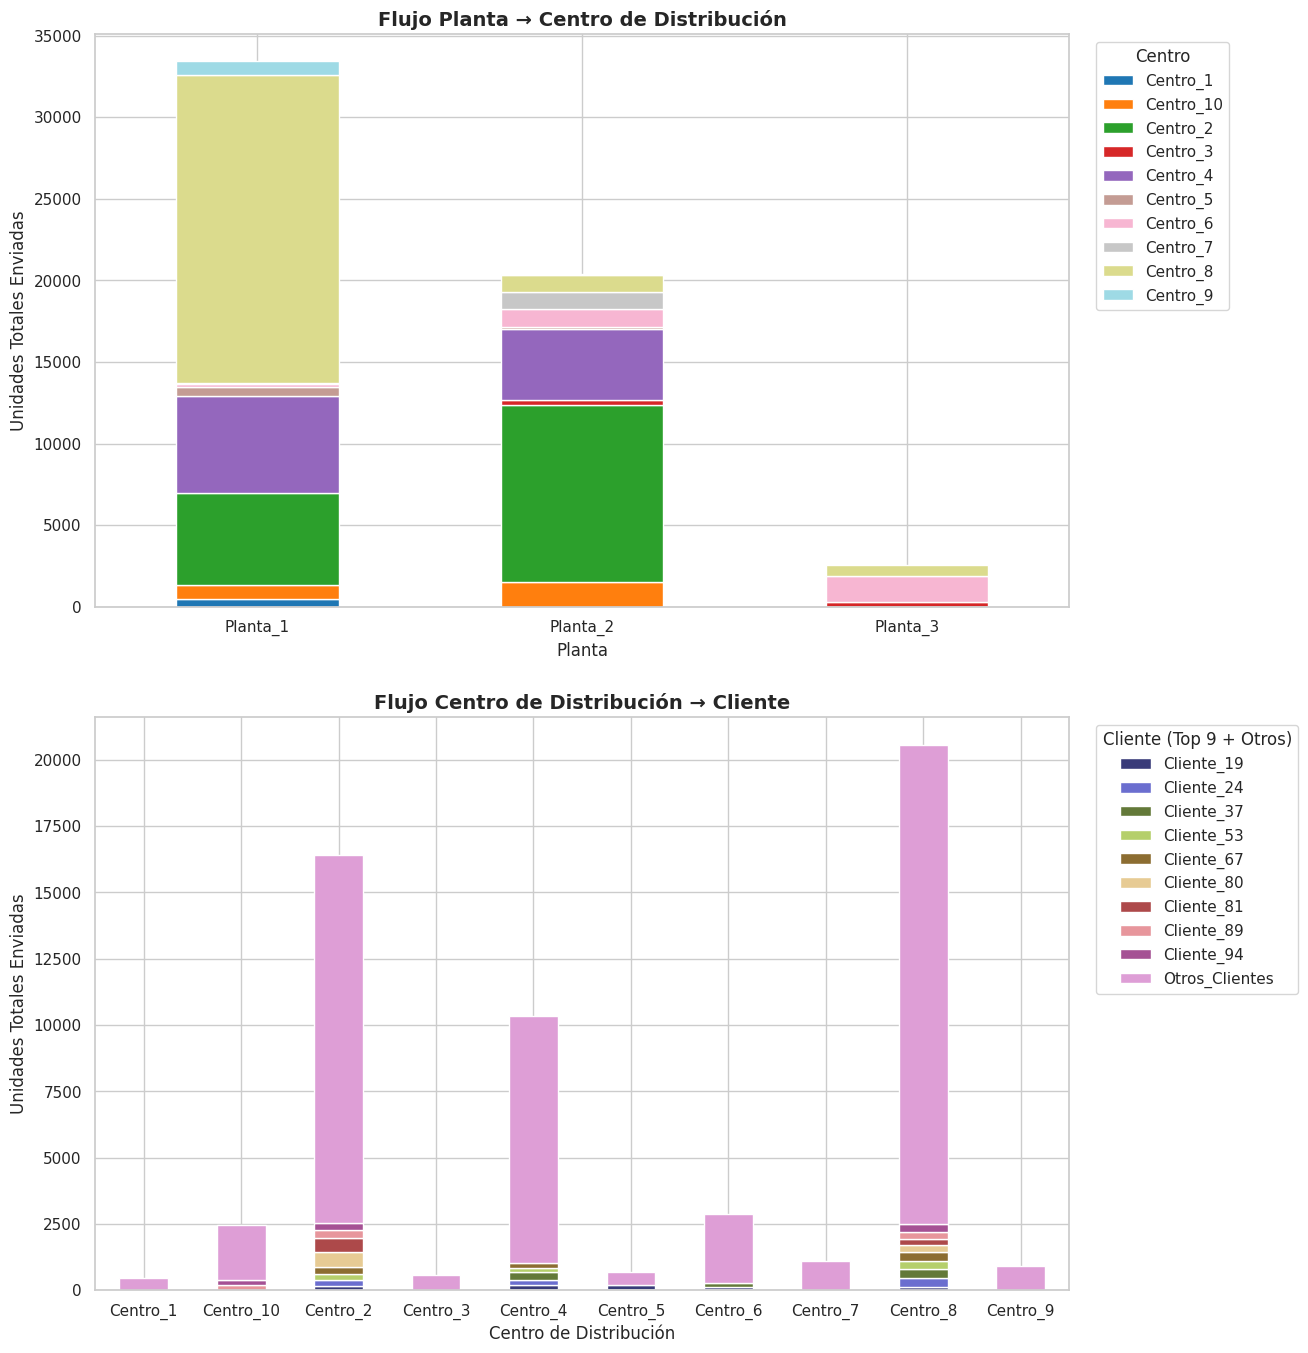


--- 2. Utilización de Capacidad (Histograma dinámico) ---


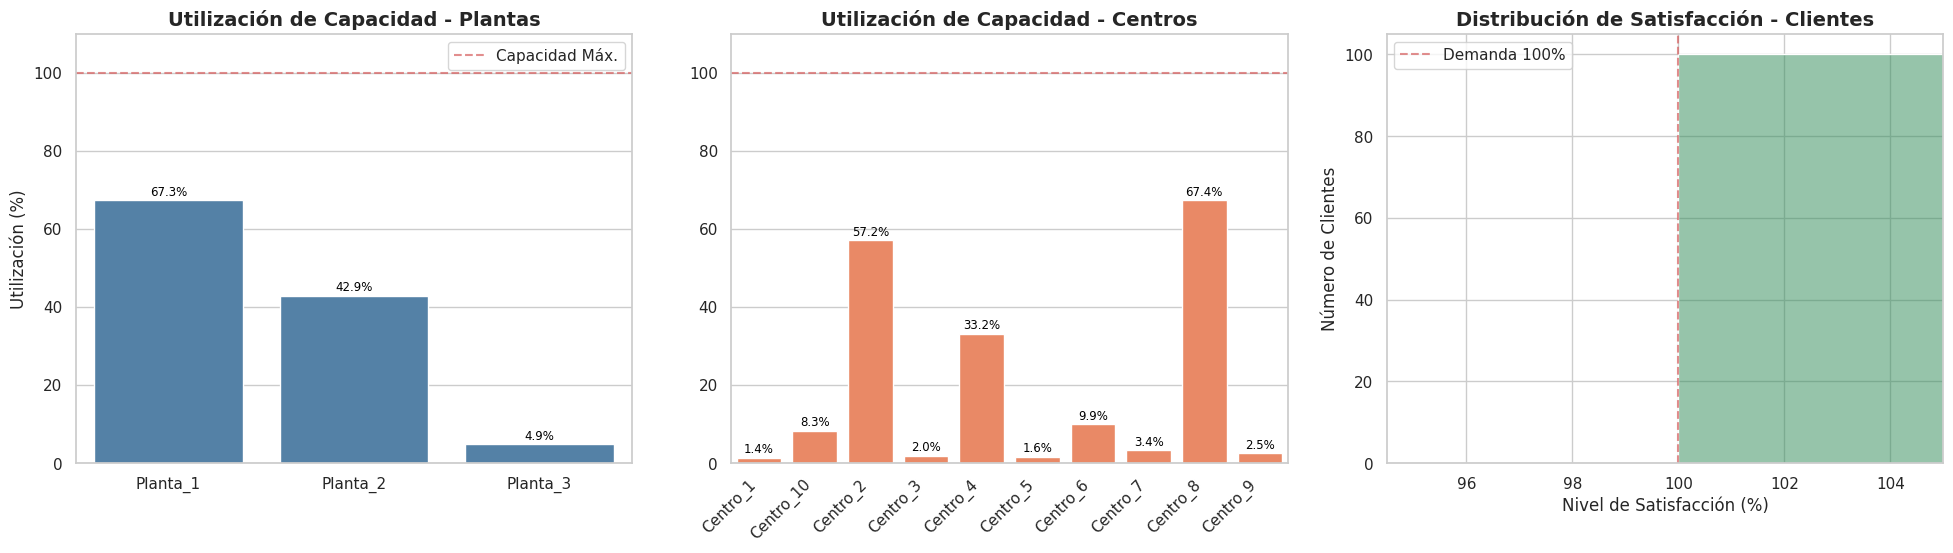


--- 3. Desglose de Costos ---


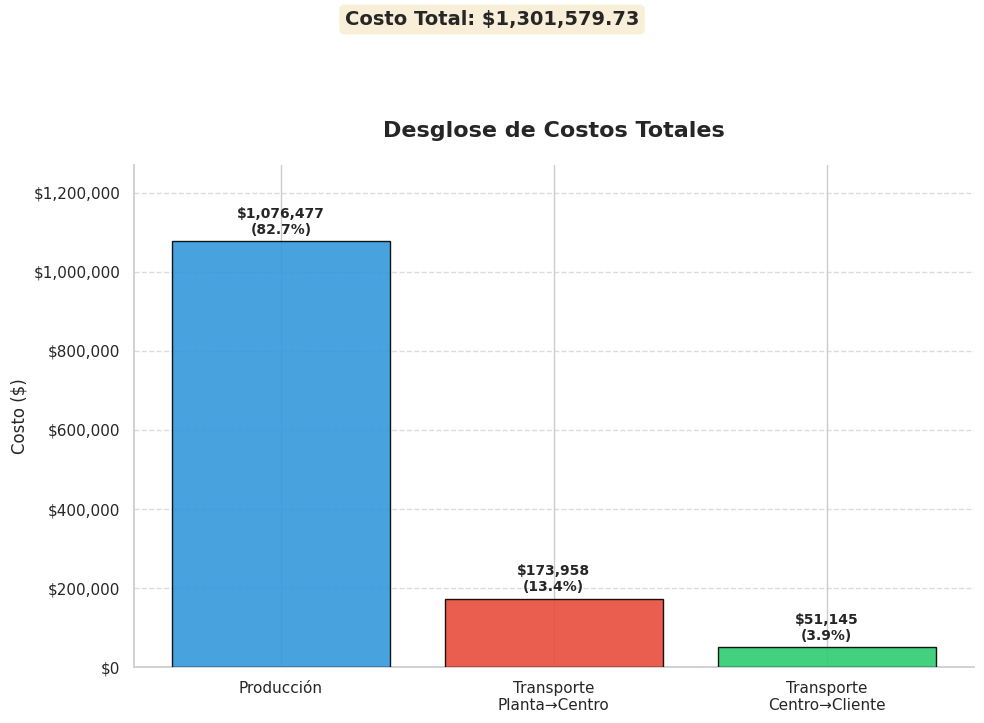

In [14]:
# ============================================================================
# EJECUCIÓN
# ============================================================================

# (Asumiendo que 'lp_model' ya existe y tiene una solución)
print("Generando visualizaciones de la solución (v3)...")
# Puedes ajustar el límite de clientes aquí si lo deseas:
# analyzer = SolutionAnalyzer(lp_model, max_clients_plot=5)
analyzer = SolutionAnalyzer(lp_model)

print("\n--- 1. Distribución de Flujos (Agrupando clientes) ---")
analyzer.plot_flow_distribution()

print("\n--- 2. Utilización de Capacidad (Histograma dinámico) ---")
analyzer.plot_utilization()

print("\n--- 3. Desglose de Costos ---")
analyzer.plot_cost_breakdown()

#

## 10. Validación de Restricciones y Función Objetivo"""

In [15]:
print("\n" + "="*70)
print("🔍 VALIDACIÓN COMPLETA DE LA SOLUCIÓN")
print("="*70)

# Verificar que hay solución
if lp_model.results is None or lp_model.results.solver.termination_condition != pyo.TerminationCondition.optimal:
    print("❌ No hay solución óptima para validar")
else:
    print("\n✅ Solución óptima encontrada - Validando restricciones...\n")

    # ==================================================================
    # 1. VALIDAR CAPACIDADES DE PRODUCCIÓN
    # ==================================================================
    print("1️⃣ CAPACIDADES DE PRODUCCIÓN")
    print("-" * 70)

    violaciones_prod = 0
    for p in lp_model.model.P:
        for k in lp_model.model.K:
            produccion = sum(pyo.value(lp_model.model.x[p, c, k]) for c in lp_model.model.C)
            capacidad = lp_model.cap_prod.get((p, k), 0)
            utilizacion = (produccion / capacidad * 100) if capacidad > 0 else 0

            if produccion > capacidad + 0.01:  # Tolerancia numérica
                print(f"   ❌ {p}, {k}: Producción={produccion:.2f} > Capacidad={capacidad:.2f}")
                violaciones_prod += 1

    if violaciones_prod == 0:
        print("   ✅ Todas las capacidades de producción respetadas")
    else:
        print(f"   ❌ {violaciones_prod} violaciones encontradas")

    # ==================================================================
    # 2. VALIDAR CAPACIDADES DE ALMACENAMIENTO
    # ==================================================================
    print("\n2️⃣ CAPACIDADES DE ALMACENAMIENTO")
    print("-" * 70)

    violaciones_alm = 0
    for c in lp_model.model.C:
        for k in lp_model.model.K:
            almacenamiento = sum(pyo.value(lp_model.model.x[p, c, k]) for p in lp_model.model.P)
            capacidad = lp_model.cap_alm.get((c, k), 0)

            if almacenamiento > capacidad + 0.01:
                print(f"   ❌ {c}, {k}: Almacenamiento={almacenamiento:.2f} > Capacidad={capacidad:.2f}")
                violaciones_alm += 1

    if violaciones_alm == 0:
        print("   ✅ Todas las capacidades de almacenamiento respetadas")
    else:
        print(f"   ❌ {violaciones_alm} violaciones encontradas")

    # ==================================================================
    # 3. VALIDAR BALANCE DE FLUJO EN CENTROS
    # ==================================================================
    print("\n3️⃣ BALANCE DE FLUJO EN CENTROS DE DISTRIBUCIÓN")
    print("-" * 70)

    violaciones_balance = 0
    for c in lp_model.model.C:
        for k in lp_model.model.K:
            entrada = sum(pyo.value(lp_model.model.x[p, c, k]) for p in lp_model.model.P)
            salida = sum(pyo.value(lp_model.model.y[c, j, k]) for j in lp_model.model.J)
            diferencia = abs(entrada - salida)

            if diferencia > 0.01:  # Tolerancia numérica
                print(f"   ❌ {c}, {k}: Entrada={entrada:.2f} ≠ Salida={salida:.2f} (Δ={diferencia:.2f})")
                violaciones_balance += 1

    if violaciones_balance == 0:
        print("   ✅ Balance de flujo perfecto en todos los centros")
    else:
        print(f"   ❌ {violaciones_balance} desbalances encontrados")

    # ==================================================================
    # 4. VALIDAR SATISFACCIÓN DE DEMANDA
    # ==================================================================
    print("\n4️⃣ SATISFACCIÓN DE DEMANDA DE CLIENTES")
    print("-" * 70)

    demanda_insatisfecha = 0
    demanda_total = 0
    demanda_entregada_total = 0

    for j in lp_model.model.J:
        for k in lp_model.model.K:
            demanda = lp_model.demanda.get((j, k), 0)
            entregado = sum(pyo.value(lp_model.model.y[c, j, k]) for c in lp_model.model.C)

            demanda_total += demanda
            demanda_entregada_total += entregado

            if entregado < demanda - 0.01:
                print(f"   ❌ {j}, {k}: Entregado={entregado:.2f} < Demanda={demanda:.2f}")
                demanda_insatisfecha += 1

    satisfaccion_pct = (demanda_entregada_total / demanda_total * 100) if demanda_total > 0 else 0

    if demanda_insatisfecha == 0:
        print(f"   ✅ Toda la demanda satisfecha ({satisfaccion_pct:.2f}%)")
    else:
        print(f"   ❌ {demanda_insatisfecha} demandas insatisfechas")
        print(f"   ⚠️ Satisfacción global: {satisfaccion_pct:.2f}%")

    # ==================================================================
    # 5. VALIDAR FUNCIÓN OBJETIVO
    # ==================================================================
    print("\n5️⃣ VALIDACIÓN DE FUNCIÓN OBJETIVO")
    print("-" * 70)

    # Calcular costo de producción
    costo_produccion_calculado = sum(
        lp_model.costo_prod.get((p, k), 0) * pyo.value(lp_model.model.x[p, c, k])
        for p in lp_model.model.P
        for c in lp_model.model.C
        for k in lp_model.model.K
    )

    # Calcular costo de transporte Planta -> Centro
    costo_trans_pc_calculado = sum(
        lp_model.costo_trans_pc.get((p, c, k), 0) * pyo.value(lp_model.model.x[p, c, k])
        for p in lp_model.model.P
        for c in lp_model.model.C
        for k in lp_model.model.K
    )

    # Calcular costo de transporte Centro -> Cliente
    costo_trans_cj_calculado = sum(
        lp_model.costo_trans_cj.get((c, j, k), 0) * pyo.value(lp_model.model.y[c, j, k])
        for c in lp_model.model.C
        for j in lp_model.model.J
        for k in lp_model.model.K
    )

    costo_total_calculado = costo_produccion_calculado + costo_trans_pc_calculado + costo_trans_cj_calculado
    costo_total_pyomo = pyo.value(lp_model.model.objetivo)
    diferencia_fo = abs(costo_total_calculado - costo_total_pyomo)

    print(f"   Costo de Producción:        ${costo_produccion_calculado:,.2f}")
    print(f"   Costo Transporte P→C:       ${costo_trans_pc_calculado:,.2f}")
    print(f"   Costo Transporte C→J:       ${costo_trans_cj_calculado:,.2f}")
    print(f"   " + "-" * 60)
    print(f"   Costo Total (calculado):    ${costo_total_calculado:,.2f}")
    print(f"   Costo Total (Pyomo):        ${costo_total_pyomo:,.2f}")
    print(f"   Diferencia:                 ${diferencia_fo:.6f}")

    if diferencia_fo < 0.01:
        print(f"   ✅ Función objetivo verificada correctamente")
    else:
        print(f"   ⚠️ Pequeña diferencia numérica (aceptable si < $1.00)")

    # ==================================================================
    # 6. RESUMEN FINAL
    # ==================================================================
    print("\n" + "="*70)
    print("📊 RESUMEN FINAL DE VALIDACIÓN")
    print("="*70)

    total_violaciones = violaciones_prod + violaciones_alm + violaciones_balance + demanda_insatisfecha

    if total_violaciones == 0 and diferencia_fo < 0.01:
        print("\n🎉 ¡SOLUCIÓN VÁLIDA Y ÓPTIMA!")
        print("   ✅ Todas las restricciones cumplidas")
        print("   ✅ Función objetivo verificada")
        print("   ✅ Balance de flujo perfecto")
        print("   ✅ Demanda 100% satisfecha")
        print(f"\n   💰 Costo Total Mínimo: ${costo_total_pyomo:,.2f}")
    else:
        print("\n⚠️ SOLUCIÓN CON ADVERTENCIAS:")
        if violaciones_prod > 0:
            print(f"   ❌ {violaciones_prod} violaciones de capacidad de producción")
        if violaciones_alm > 0:
            print(f"   ❌ {violaciones_alm} violaciones de capacidad de almacenamiento")
        if violaciones_balance > 0:
            print(f"   ❌ {violaciones_balance} desbalances de flujo")
        if demanda_insatisfecha > 0:
            print(f"   ❌ {demanda_insatisfecha} demandas insatisfechas")
        if diferencia_fo >= 0.01:
            print(f"   ⚠️ Diferencia en función objetivo: ${diferencia_fo:.2f}")

    print("="*70)


🔍 VALIDACIÓN COMPLETA DE LA SOLUCIÓN

✅ Solución óptima encontrada - Validando restricciones...

1️⃣ CAPACIDADES DE PRODUCCIÓN
----------------------------------------------------------------------
   ✅ Todas las capacidades de producción respetadas

2️⃣ CAPACIDADES DE ALMACENAMIENTO
----------------------------------------------------------------------
   ✅ Todas las capacidades de almacenamiento respetadas

3️⃣ BALANCE DE FLUJO EN CENTROS DE DISTRIBUCIÓN
----------------------------------------------------------------------
   ✅ Balance de flujo perfecto en todos los centros

4️⃣ SATISFACCIÓN DE DEMANDA DE CLIENTES
----------------------------------------------------------------------
   ✅ Toda la demanda satisfecha (100.00%)

5️⃣ VALIDACIÓN DE FUNCIÓN OBJETIVO
----------------------------------------------------------------------
   Costo de Producción:        $1,076,477.00
   Costo Transporte P→C:       $173,958.07
   Costo Transporte C→J:       $51,144.66
   ---------------------

## 9. Exportar Solución

In [16]:
class SolutionExporter:
    """Exporta la solución a archivos CSV."""

    @staticmethod
    def export_solution(lp_model: DistributionNetworkLP,
                       output_prefix: str = 'solucion_pyomo'):
        """Exporta la solución a archivos CSV."""

        df_pc, df_cj = lp_model.get_solution_dataframes()

        df_pc.to_csv(f'{output_prefix}_flujo_planta_centro.csv', index=False)
        print(f"✅ Exportado: {output_prefix}_flujo_planta_centro.csv")

        df_cj.to_csv(f'{output_prefix}_flujo_centro_cliente.csv', index=False)
        print(f"✅ Exportado: {output_prefix}_flujo_centro_cliente.csv")

        costo_produccion = sum(
            lp_model.costo_prod.get((p, k), 0) * pyo.value(lp_model.model.x[p, c, k])
            for p in lp_model.sets['plantas']
            for c in lp_model.sets['centros']
            for k in lp_model.sets['productos']
        )

        costo_trans_pc = sum(
            lp_model.costo_trans_pc.get((p, c, k), 0) * pyo.value(lp_model.model.x[p, c, k])
            for p in lp_model.sets['plantas']
            for c in lp_model.sets['centros']
            for k in lp_model.sets['productos']
        )

        costo_trans_cj = sum(
            lp_model.costo_trans_cj.get((c, j, k), 0) * pyo.value(lp_model.model.y[c, j, k])
            for c in lp_model.sets['centros']
            for j in lp_model.sets['clientes']
            for k in lp_model.sets['productos']
        )

        resumen = pd.DataFrame([{
            'costo_produccion': costo_produccion,
            'costo_transporte_planta_centro': costo_trans_pc,
            'costo_transporte_centro_cliente': costo_trans_cj,
            'costo_total': costo_produccion + costo_trans_pc + costo_trans_cj,
            'metodo': 'Programacion Lineal (Pyomo + CBC)'
        }])
        resumen.to_csv(f'{output_prefix}_resumen_costos.csv', index=False)
        print(f"✅ Exportado: {output_prefix}_resumen_costos.csv\n")

        return df_pc, df_cj, resumen

# Exportar
df_planta_centro, df_centro_cliente, df_resumen = SolutionExporter.export_solution(lp_model)

print("\n📊 RESUMEN DE FLUJOS PLANTA → CENTRO")
display(df_planta_centro.head(10))

print("\n📊 RESUMEN DE FLUJOS CENTRO → CLIENTE")
display(df_centro_cliente.head(10))

print("\n💰 RESUMEN DE COSTOS")
display(df_resumen)

✅ Exportado: solucion_pyomo_flujo_planta_centro.csv
✅ Exportado: solucion_pyomo_flujo_centro_cliente.csv
✅ Exportado: solucion_pyomo_resumen_costos.csv


📊 RESUMEN DE FLUJOS PLANTA → CENTRO


,planta,centro,producto,cantidad
0,Planta_1,Centro_1,Producto_1,156.0
1,Planta_1,Centro_1,Producto_3,295.0
2,Planta_1,Centro_10,Producto_1,909.0
3,Planta_1,Centro_2,Producto_1,5556.0
4,Planta_1,Centro_2,Producto_2,32.0
5,Planta_1,Centro_4,Producto_4,5993.0
6,Planta_1,Centro_5,Producto_2,541.0
7,Planta_1,Centro_6,Producto_4,151.0
8,Planta_1,Centro_7,Producto_1,64.0
9,Planta_1,Centro_8,Producto_2,9439.0



📊 RESUMEN DE FLUJOS CENTRO → CLIENTE


,centro,cliente,producto,cantidad
0,Centro_1,Cliente_12,Producto_3,179.0
1,Centro_1,Cliente_4,Producto_3,60.0
2,Centro_1,Cliente_6,Producto_3,56.0
3,Centro_1,Cliente_9,Producto_1,156.0
4,Centro_10,Cliente_13,Producto_1,47.0
5,Centro_10,Cliente_14,Producto_1,153.0
6,Centro_10,Cliente_16,Producto_1,148.0
7,Centro_10,Cliente_16,Producto_4,140.0
8,Centro_10,Cliente_20,Producto_1,81.0
9,Centro_10,Cliente_4,Producto_4,47.0



💰 RESUMEN DE COSTOS


,costo_produccion,costo_transporte_planta_centro,costo_transporte_centro_cliente,costo_total,metodo
0,1076477.0,173958.07,51144.66,1301579.73,Programacion Lineal (Pyomo + CBC)


## 10. Conclusiones

### Resultados Obtenidos

Este notebook implementó **Programación Lineal con Pyomo** para resolver el problema de optimización de red de distribución multinivel, demostrando:

1. **Optimalidad Garantizada**: Se encontró la solución de costo mínimo global
2. **Eficiencia Computacional**: Resolución en pocos segundos vs minutos con AG
3. **Interpretabilidad**: Análisis de sensibilidad y variables duales
4. **Robustez**: Solución determinística y reproducible

### Comparación: Programación Lineal vs Algoritmos Genéticos

| Aspecto | Programación Lineal | Algoritmos Genéticos |
|---------|---------------------|----------------------|
| **Optimalidad** | ✅ Garantizada | ❌ Aproximada |
| **Velocidad** | ✅ ~5 segundos | ⚠️ ~3-5 minutos |
| **Escalabilidad** | ✅ Miles de variables | ⚠️ Limitado |
| **Reproducibilidad** | ✅ 100% | ❌ Variable |
| **Análisis** | ✅ Variables duales | ❌ Ninguno |

### Aplicaciones Industriales

- **Cadenas de Suministro**: Diseño y operación de redes logísticas
- **Planificación de Producción**: Asignación óptima de recursos
- **Gestión de Inventarios**: Balance entre costos y servicio
- **Transporte y Distribución**: Rutas y asignaciones óptimas

### Referencias

- **Presentación del Dr. Rivera**: "Programación para Analítica Prescriptiva"
- **Pyomo Documentation**: http://www.pyomo.org/
- **COIN-OR CBC**: https://github.com/coin-or/Cbc
- Bertsimas, D., & Tsitsiklis, J. N. (1997). Introduction to Linear Optimization

---

**Elaborado por**: MIAAD - Universidad Autónoma de Ciudad Juárez  
**Profesor**: Dr. Gilberto Rivera Zárate  
**Curso**: Programación para Analítica Prescriptiva y Soporte a Decisiones  
**Método**: Programación Lineal con Pyomo y CBC